<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 14th exercise: <font color="#C70039">Deep Learning: Long Short-Term Memory (LSTM)</font>
* Course: <a href="https://www.gernotheisenberg.de/time_series_forecasting.html">Time Series Forecasting (TSF)</a>
* Lecturer: <a href="https://www.gernotheisenberg.de/uebermich.html">Gernot Heisenberg</a>
* Date:   08.06.2025

<img src="./images/LSTM.png" style="float: center;" width="450">

---------------------------------
**GENERAL NOTE 1**:
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole.

**GENERAL NOTE 2**:
* Please, when commenting source code, just use English language only.
* When describing an observation please use English language, too
* This applies to all exercises throughout this course.  

---------------------

### <font color="ce33ff">DESCRIPTION OF THE NOTEBOOK CONTENT</font>:
This notebook allows you for learning about how to forcast times series with LSTM models. These models will be implemented as a single-step model, a multi-step model and a multi-output model, respectively.

-------------------------------------------------------------------------------------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points.
If a task is more challenging and consists of several steps, this is indicated as well.
Make sure you have worked down the task list and commented your doings.
This should be done by using markdown.<br>
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date.
    * set the date too and remove mine.
3. read the entire notebook carefully
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time
    * understand the output
4. Take the air pollution data set from the exercises 12 and 13.
    * Prepare three LSTM models (SingleStep, MultiStep and SingleStep-MultiOutput)
        * Plot its predictions
        * Evaluate it using the MAE and store the MAE
            * Is it the most performant model?
    * Experiment with the LSTM itself
        * e.g. add more LSTM layers
        * e.g. change the number of units in the LSTM layer
-----------------------------------------------------------------------------------

In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [2]:
# as always, set some useful parameters
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

tf.random.set_seed(42)
np.random.seed(42)

In [4]:
# load the traffic volume dataset and print the shape  
train_df = pd.read_csv('./data/DL/train.csv', index_col=0)
val_df = pd.read_csv('./data/DL/val.csv', index_col=0)
test_df = pd.read_csv('./data/DL/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)
(12285, 5) (3510, 5) (1756, 5)


#### <font color = red>NOTE</font>
The class DataWindow() remains unchanged and can be copied from Ex13 where it was implemented.

In [5]:
class DataWindow():
    '''the initialization function of the class assigns the variables and manages the indices of the inputs and the labels.'''
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # Name of the column that we wish to predict
        self.label_columns = label_columns
        if label_columns is not None:
            # Create a dict with the name and index of the label column.
            # This will be used for visulization later.
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        # Create a dict with the name and index of each column. 
        # This will be used to separate the features from the target variable.
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        
        ''' The slice function returns a slice object that specifies how
            to slice a sequence. In this case, it says that the input slice 
            starts at 0 and ends when we reach the input_width.'''
        self.input_slice = slice(0, input_width)
        # Assign indices to the inputs. These are useful for visualization.
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        # Get the index at which the label starts. In this case, it is the total window size minus the width of the label.
        self.label_start = self.total_window_size - self.label_width
        # The same steps that were applied for the inputs are applied for labels, too.
        self.label_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.label_slice]
    
    ''' The split_to_inputs_labels() function splits the window between inputs and labels, 
        so that the models, later, can make predictions based on the inputs and measure an error metric against the labels.
        It will separate the big data window into two windows: 
        one for the inputs and the other for the labels, as shown in the lecture slides!'''
    def split_to_inputs_labels(self, features):
        # slice the window to get the inputs using the input_slice defined in __init__.
        inputs = features[:, self.input_slice, :]
        # slice the window to get the labels using the labels_slice defined in __init__.
        labels = features[:, self.label_slice, :]
        # If there is more than one target let's stack the labels.
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        # The shape will be [batch, time, features]. 
        # At this point, we only specify the time dimension and allow the batch and feature dimensions
        # to be defined later (see below).    
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    ''' Define a function to plot the input data, the predictions and the actual values for comparison. 
        
        Since we will be working with many time windows, we’ll show only the plot of three time windows (default max_subplots), 
        but this parameter can easily be changed. 
        
        Also, the default label will be traffic volume, but we can change that by specifying any column we choose. '''
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        # get the data
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            # Plot the inputs. They will appear as a continuous blue line with dots . !
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue
            # Plot the labels (actual values). They will appear as green squares.
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
                predictions = model(inputs)
            # Plot the predictions. They will appear as red crosses.
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions', c='red', s=64)

            if n == 0: 
                plt.legend()

        plt.xlabel('Time (h)')
    
    ''' Format the dataset into tensors so that it can be fed to the DL models.
        TensorFlow comes with a very handy function called timeseries_dataset_from_array(), 
        which creates a dataset of sliding windows, given an array.'''
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            # pass in the data. This corresponds to our training set, validation set or test set.
            data=data,
            # targets are set to None, as they are handled by the split_to_input_labels() function.
            targets=None,
            # set the total length of the array, which is equal to the total window length.
            sequence_length=self.total_window_size,
            # set stride = the number of timesteps separating each sequence. 
            # if you want the sequences to be consecutive, so sequence_stride=1.
            sequence_stride=1,
            # shuffle the sequences. Keep in mind that the data is still in chronological order. 
            # we are simply shuffling the order of the sequences, which makes the model more robust (see lecture slides).
            shuffle=True,
            # set the number of sequences in a single batch.
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    ''' Define some properties to apply the make_dataset() function on the training, validation and testing sets.'''
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    # Get a sample batch of data for visualization purposes. 
    # If the sample batch does not exist, then retrieve a sample batch and cache it.
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

### <font color = red>NOTE</font>
Now, there is a need to define a compile_and_fit() function that configures the model for training and then
fits the model on the data.

The function takes a model and a window of data from the DataWindow class. 
The patience is the number of epochs after which the model should stop training if the validation loss does not improve; max_epochs sets a maximum number of epochs to train the model.

In [6]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    ''' Early stopping occurs if 3 consecutive epochs do not decrease the
        validation loss, as set by the patience parameter.'''
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    ''' the MSE is taken as the loss function
        The MAE is used as an error metric.'''
    model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[MeanAbsoluteError()])

    ''' The model can train for at most 50 epochs, as set by the max_epochs parameter.
        early_stopping is passed as a callback. If the validation loss does not decrease after
        3 consecutive epochs, the model stops training. This avoids overfitting.'''
    history = model.fit(window.train, epochs=max_epochs,validation_data=window.val, 
                        callbacks=[early_stopping])

    return history

In [7]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Setup of the LSTM models

Since the compile_and_fit() function works, we can move on and start designing the different versions of LSTM models in the different sections of this notebook.

We will implement LSTM as a single-step model, a multi-step model, and a multi-output
model. 

The single-step model will predict the traffic volume for the next timestep only. 

The multi-step model will predict the traffic volume for the next 24 hours.

The multi-output model will predict the temperature and traffic volume for the next timestep.

### PART I - Single-step model

First, create a data window to train the model. This will be a wide window, with 24 hours of data as input.

For visulization purposes again, the label_width is also 24, so that we can compare the predictions to the actual values over 24 timesteps.
Note that this is still a single-step model, so over 24 hours the model will only predict one timestep at a time, just like a rolling forecast (shift=1).

In [8]:
st_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

Then, define the LSTM model in Keras. For this purpose, use the Sequential model to allow for stacking  different layers in the network. Keras conveniently comes with the LSTM layer, which implements an LSTM. 
Set the return_sequences to True, as this signals Keras to use past information from the sequence, 
in the form of the hidden state and cell state, which we covered during the course and you can find it in the lecture slides. 
Finally, we’ll define the output layer, which is simply a Dense layer with one unit because 
we are forecasting the traffic volume only.

Then, pass the model into the compile_and_fit() function and cache the performance metrics on both, the validation and the test partition.

In [10]:
st_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=1)
])

history = compile_and_fit(st_lstm_model, st_wide_window)

st_val_performance = {}
st_performance = {}

st_val_performance['LSTM'] = st_lstm_model.evaluate(st_wide_window.val)
st_performance['LSTM'] = st_lstm_model.evaluate(st_wide_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.0489 - mean_absolute_error: 0.1617 - val_loss: 0.0110 - val_mean_absolute_error: 0.0766
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0087 - mean_absolute_error: 0.0674 - val_loss: 0.0049 - val_mean_absolute_error: 0.0501
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0048 - mean_absolute_error: 0.0492 - val_loss: 0.0040 - val_mean_absolute_error: 0.0448
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0040 - mean_absolute_error: 0.0440 - val_loss: 0.0034 - val_mean_absolute_error: 0.0412
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0036 - mean_absolute_error: 0.0413 - val_loss: 0.0031 - val_mean_absolute_error: 0.0392
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0032 - mean_absolute_error: 0.0391 - val_loss: 0.0029 - val_mean_absolute_error: 0.0370
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0031 - mean_absolute_error: 0.0377 

In [ ]:
#### Visualization of the performance of the single timestep LSTM model

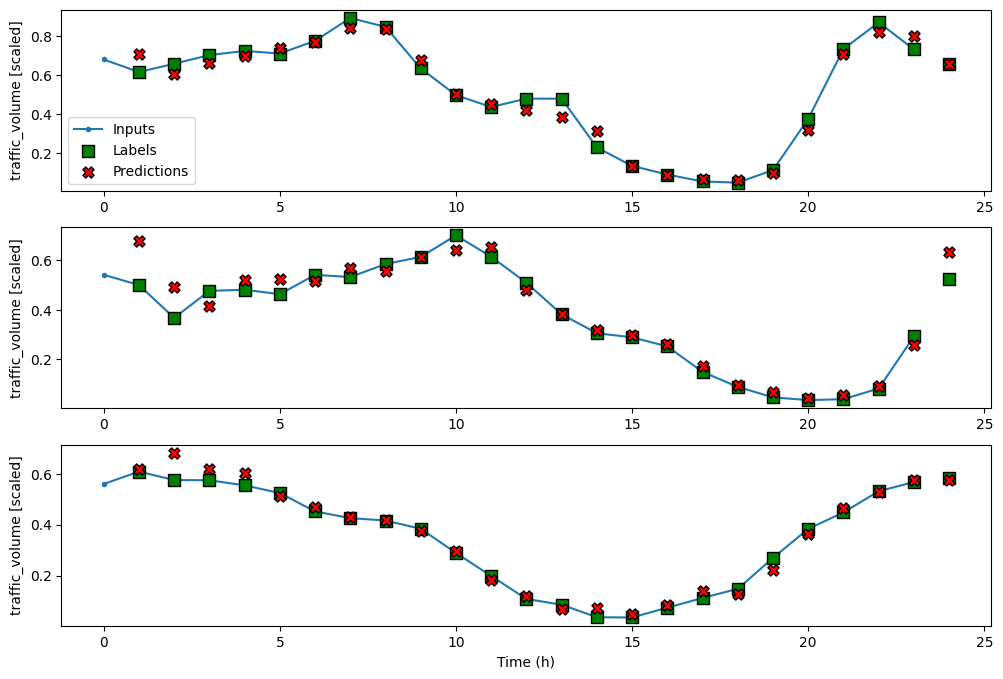

In [11]:
st_wide_window.plot(st_lstm_model)

Predicting traffic volume using an LSTM as a single-step model. Many predictions (shown as crosses) 
overlap the labels (shown as squares), suggesting we have a performant model with accurate predictions.

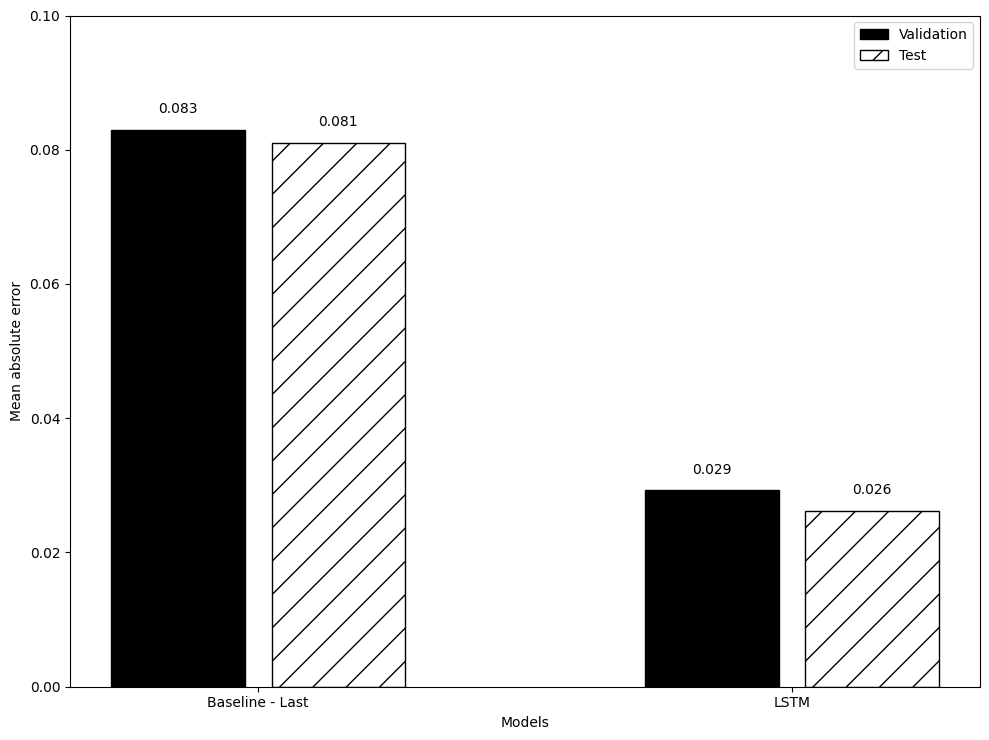

In [27]:
# performance values obtained from Ex13 for baseline-last
st_mae_val = [0.083]
st_mae_test = [0.081]

# add performance from LSTM
st_mae_val.append(st_val_performance['LSTM'][1])
st_mae_test.append(st_performance['LSTM'][1])

x = np.arange(2)

# create the plotting labels
labels = ['Baseline - LastValue', 'LSTM-SingleStep']

fig, ax = plt.subplots()
ax.bar(x - 0.15, st_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, st_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(st_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(st_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

The MAE confirms the performance of the single timestep LSTM model.

### PART II - Multi-step model

Implementing the LSTM architecture as a multi-step model means we wish to predict traffic volume for next 24 hours, using an input window of 24 hours. The DataWindow class has to be provided with the new parameters accordingly.

The fit_and_compile() function remains unchanged. Also the definition of the multi-step model and single-step model remains exactly the same. 

In [13]:
ms_multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

In [15]:
ms_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),])

history = compile_and_fit(ms_lstm_model, ms_multi_window)

ms_val_performance = {}
ms_test_performance = {}

# cache the performance values again
ms_val_performance['LSTM'] = ms_lstm_model.evaluate(ms_multi_window.val)
ms_test_performance['LSTM'] = ms_lstm_model.evaluate(ms_multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0906 - mean_absolute_error: 0.2261 - val_loss: 0.0206 - val_mean_absolute_error: 0.1012
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0176 - mean_absolute_error: 0.0925 - val_loss: 0.0182 - val_mean_absolute_error: 0.0931
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0155 - mean_absolute_error: 0.0846 - val_loss: 0.0168 - val_mean_absolute_error: 0.0847
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0149 - mean_absolute_error: 0.0817 - val_loss: 0.0163 - val_mean_absolute_error: 0.0844
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0143 - mean_absolute_error: 0.0800 - val_loss: 0.0159 - val_mean_absolute_error: 0.0839
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0140 - mean_absolute_error: 0.0791 - val_loss: 0.0159 - val_mean_absolute_error: 0.0864
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0138 - mean_absolute_error: 0.0784 -

#### Visualization of the performance of the multi-timestep LSTM model

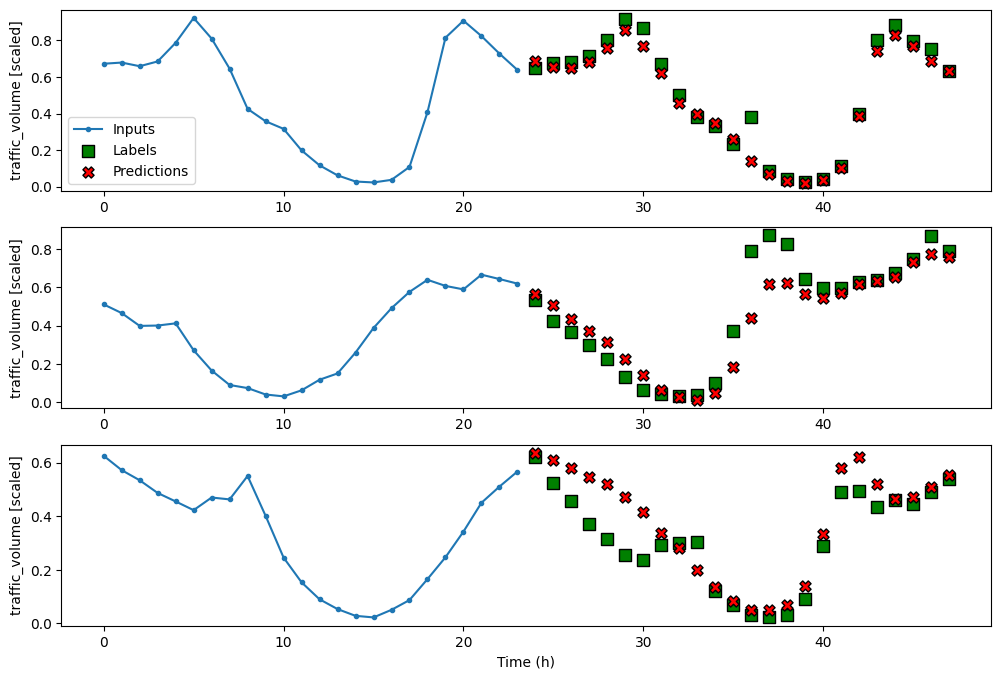

In [16]:
ms_multi_window.plot(ms_lstm_model)

Predicting the traffic volume over the next 24 hours using a multi-step LSTM model. 
We can see some discrepancies between the predictions and the labels. However, this visual inspection is not enough
to assess the performance of the model.

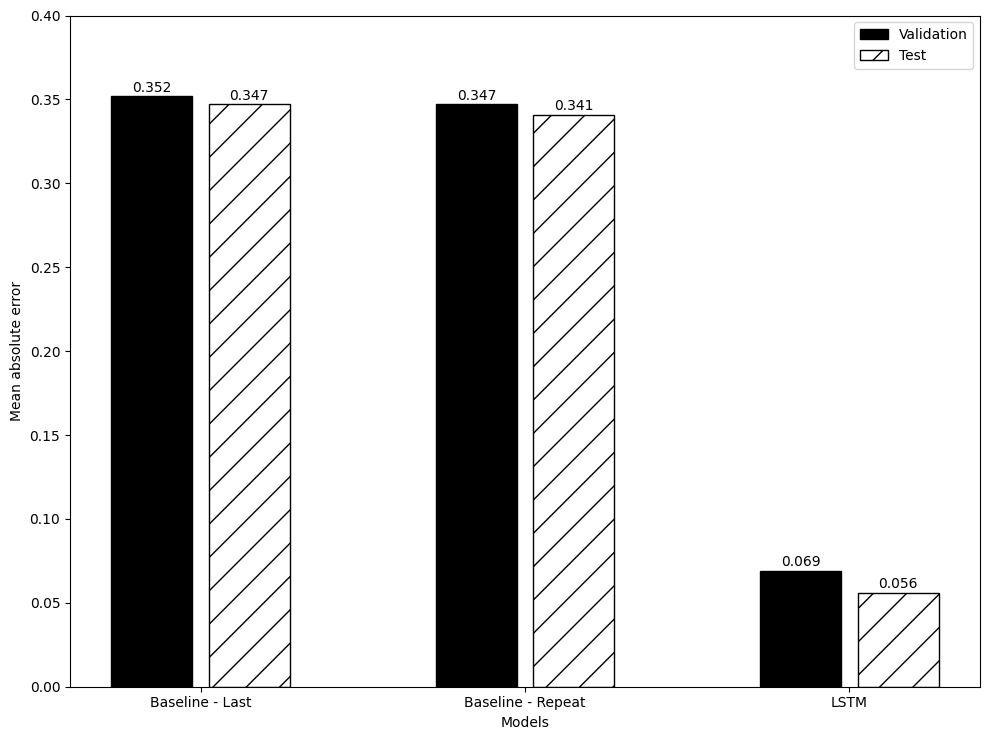

In [29]:
# performance values obtained from Ex13 
# for the 'Baseline - LastValue' and 'Baseline - RepeatedValue'
ms_mae_val = [0.352, 0.347]
ms_mae_test = [0.347, 0.341]

# add performance of the LSTM
ms_mae_val.append(ms_val_performance['LSTM'][1])
ms_mae_test.append(ms_test_performance['LSTM'][1])

x = np.arange(3)
# create the labels for plotting
labels = ['Baseline - LastValue', 'Baseline - RepeatedValue', 'LSTM-MultiStep']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

As we can see, the MAE of the LSTM as multi-timestep model outperforms the baseline models is the winning model for both, the validation as well as the test set.

### PART III - Multi-output model

In the third part the data window consists of an input of 24 timesteps and 24 timesteps of labels. 
The shift is 1 again, as we want to produce forecasts for the next timestep only.
Thus, our model will be creating rolling forecasts to generate predictions one timestep
at a time, over 24 timesteps. We’ll specify temp and traffic_volume as our target columns, as we did before many times already (remeber that mo_wide_window is for visualization purposes).

The next step is to define our LSTM model. Just as before, we’ll use the Sequential
model to stack an LSTM layer and a Dense output layer with two units, since we have
two targets.

The rest remains unchanged.

In [18]:
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

In [20]:
mo_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units = 2) # use two units, since there are two labels/targets to predict
])

history = compile_and_fit(mo_lstm_model, mo_wide_window)

mo_val_performance = {}
mo_test_performance = {}

# cache the model performance
mo_val_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.val)
mo_test_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0509 - mean_absolute_error: 0.1580 - val_loss: 0.0076 - val_mean_absolute_error: 0.0550
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0058 - mean_absolute_error: 0.0482 - val_loss: 0.0035 - val_mean_absolute_error: 0.0375
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0034 - mean_absolute_error: 0.0371 - val_loss: 0.0026 - val_mean_absolute_error: 0.0326
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0028 - mean_absolute_error: 0.0336 - val_loss: 0.0023 - val_mean_absolute_error: 0.0307
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0026 - mean_absolute_error: 0.0316 - val_loss: 0.0020 - val_mean_absolute_error: 0.0290
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0024 - mean_absolute_error: 0.0301 - val_loss: 0.0019 - val_mean_absolute_error: 0.0275
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0022 - mean_absolute_error: 0.0287 -

#### Visualization of the performance of the multi-output LSTM model

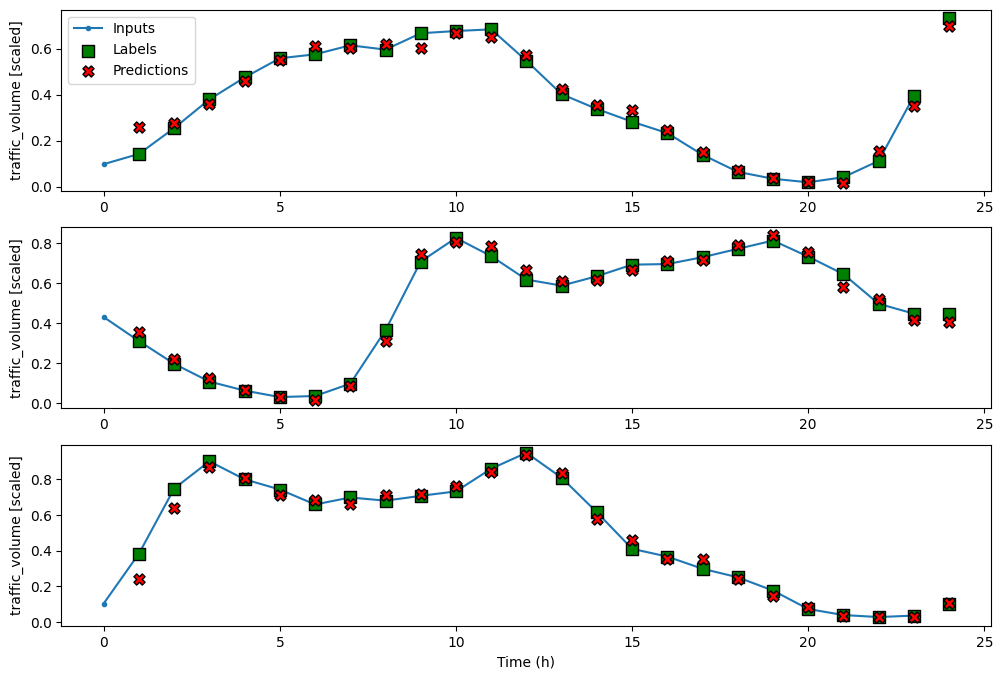

In [21]:
mo_wide_window.plot(mo_lstm_model)

Predicting the traffic volume with an LSTM as a multi-output model. Many predictions (shown as crosses) overlap the labels (shown as squares), suggesting very accurate predictions for the traffic volume.

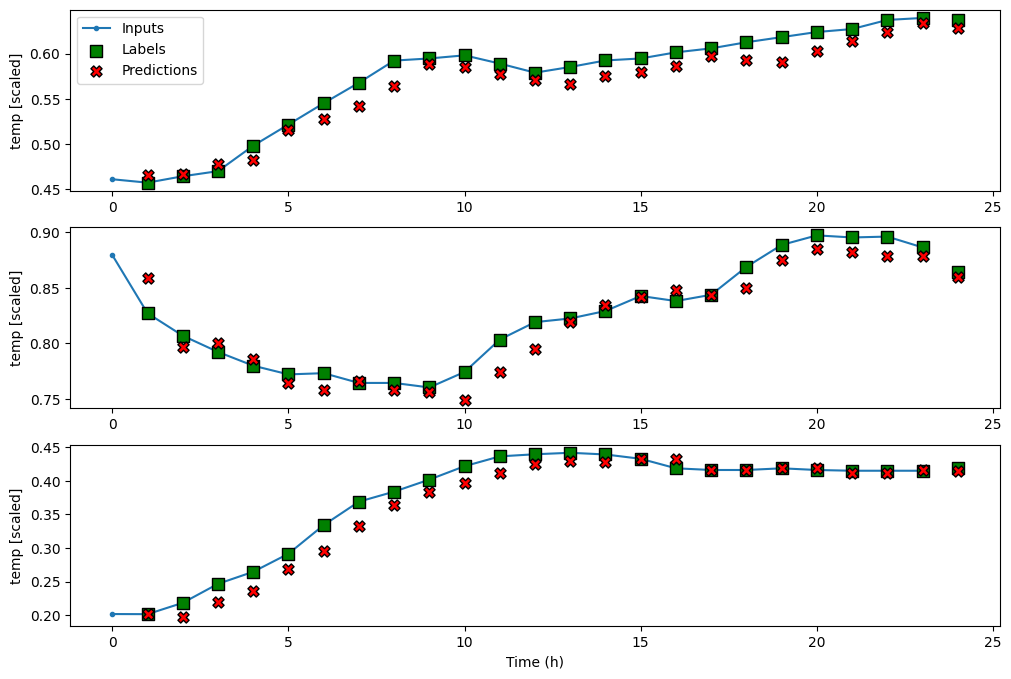

In [22]:
mo_wide_window.plot(model=mo_lstm_model, plot_col='temp')

Predicting the temperature using an LSTM as a multi-output model. Again, we see a lot of
overlap between the predictions (shown as crosses) and the labels (shown as squares), indicating accurate predictions.

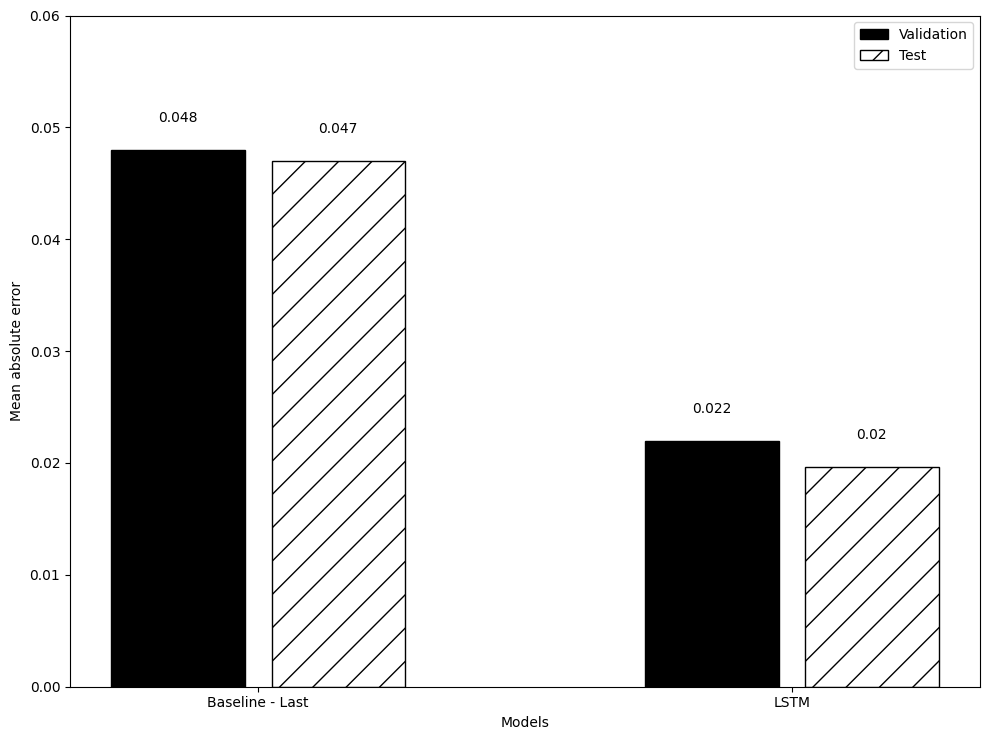

In [30]:
# performance values obtained from Ex13 for baseline-last
mo_mae_val = [0.048]
mo_mae_test = [0.047]

# add performance of the multi-output LSTM
mo_mae_val.append(mo_val_performance['LSTM'][1])
mo_mae_test.append(mo_test_performance['LSTM'][1])

x = np.arange(2)

# create the labels for plotting
labels = ['Baseline - LastValue', 'LSTM-ST_MultiOutput']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

The MAE of all the multi-output models built so far. Again, the winning model is the LSTM, as it achieved the lowest MAE.